In [134]:
import pandas as pd
import os
from datetime import datetime
from matplotlib import pyplot as plt
import json

%matplotlib inline

Данные загружены <a href="https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv"> отсюда</a> (тут же можно посмотреть и описание). Это данные о продаже разных товаров в Бразилии

In [2]:
os.listdir("data")

['olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

Давайте ответим на пару вопросов.

1) Найти топ-10 покупателей по потраченной сумме

2) Самые популярные категории товаров (для каждой категории найти число покупок, средний чек)

3) Найти распределение времени доставки

4) Для каждого селлера найти его рейтинг, как среднее оценок покупателей по заказам селлера

5) Найти "локальных" селлеров: тех, кто продает в основном только в своем штате (среди их продаж доля в своем штате наибольшая)

In [92]:
orders_data = pd.read_csv('data/olist_orders_dataset.csv')

In [93]:
orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [94]:
orders_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [95]:
payments_data = pd.read_csv('data/olist_order_payments_dataset.csv')

In [96]:
payments_data.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [97]:
orders_data['order_status'].value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

In [98]:
orders_data['order_status'] == 'delivered'

0        True
1        True
2        True
3        True
4        True
         ... 
99436    True
99437    True
99438    True
99439    True
99440    True
Name: order_status, Length: 99441, dtype: bool

In [99]:
orders_data = orders_data[orders_data['order_status'] == 'delivered']

In [100]:
orders_data.shape

(96478, 8)

In [101]:
orders_data.drop_duplicates(subset=['order_id'], inplace=True)
payments_data.drop_duplicates(subset=['order_id'], inplace=True)

In [102]:
print("Orders shape: ", orders_data.shape)
print("Payments shape: ", payments_data.shape)

Orders shape:  (96478, 8)
Payments shape:  (99440, 5)


## Top-10 customers

In [24]:
orders_with_payments = orders_data.merge(payments_data, on=['order_id'])

In [25]:
orders_with_payments.shape

(96477, 12)

In [26]:
orders_with_payments.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,1,141.46


In [28]:
customers_aggr = orders_with_payments.groupby('customer_id').agg({'payment_value': ['sum', 'count']})

In [30]:
customers_aggr.columns

MultiIndex([('payment_value',   'sum'),
            ('payment_value', 'count')],
           )

In [33]:
customers_aggr.sort_values(by=('payment_value',   'sum'), ascending=False)[0:10]

payment_value      
                                           sum count
customer_id                                         
1617b1357756262bfa56ab541c47bc16      13664.08     1
ec5b2ba62e574342386871631fafd3fc       7274.88     1
c6e2731c5b391845f6800c97401a43a9       6929.31     1
f48d464a0baaea338cb25f816991ab1f       6922.21     1
3fd6777bbce08a352fddd04e4a7cc8f6       6726.66     1
05455dfa7cd02f13d132aa7a6a9729c6       6081.54     1
df55c14d1476a9a3467f131269c2477f       4950.34     1
24bbf5fd2f2e1b359ee7de94defc4a15       4764.34     1
3d979689f636322c62418b6346b1c6d2       4681.78     1
1afc82cd60e303ef09b4ef9837c9505c       4513.32     1

## Top categories

In [35]:
order_items = pd.read_csv('data/olist_order_items_dataset.csv')

In [37]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [38]:
products_data = pd.read_csv('data/olist_products_dataset.csv')

In [40]:
products_data.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [41]:
products_data = products_data[['product_id', 'product_category_name']]

In [42]:
products_data.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [45]:
print("Unique values: ", products_data['product_id'].nunique())
print("All values: ", products_data.shape[0])

Unique values:  32951
All values:  32951


In [47]:
items_with_categories = order_items.merge(products_data, on='product_id')

In [61]:
categories_stat = items_with_categories.groupby('product_category_name').agg({'price': ['sum', 'count', 'mean']})\
                        .sort_values(by=('price', 'sum'), ascending=False)

In [62]:
categories_stat.head()

price                   
                               sum  count        mean
product_category_name                                
beleza_saude            1258681.34   9670  130.163531
relogios_presentes      1205005.68   5991  201.135984
cama_mesa_banho         1036988.68  11115   93.296327
esporte_lazer            988048.97   8641  114.344285
informatica_acessorios   911954.32   7827  116.513903

In [60]:
translations = pd.read_csv('data/product_category_name_translation.csv')
translations.set_index(keys='product_category_name', inplace=True)
translations.head()

,product_category_name_english
product_category_name,
beleza_saude,health_beauty
informatica_acessorios,computers_accessories
automotivo,auto
cama_mesa_banho,bed_bath_table
moveis_decoracao,furniture_decor


In [66]:
categories_stat = categories_stat.merge(translations, left_index=True, right_index=True)

C:\Users\Brux\anaconda3\lib\site-packages\pandas\core\frame.py:9199: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


In [67]:
categories_stat.head()

,"(price, sum)","(price, count)","(price, mean)",product_category_name_english
product_category_name,,,,
beleza_saude,1258681.34,9670,130.163531,health_beauty
relogios_presentes,1205005.68,5991,201.135984,watches_gifts
cama_mesa_banho,1036988.68,11115,93.296327,bed_bath_table
esporte_lazer,988048.97,8641,114.344285,sports_leisure
informatica_acessorios,911954.32,7827,116.513903,computers_accessories


In [70]:
list(categories_stat['product_category_name_english'])

['health_beauty',
 'watches_gifts',
 'bed_bath_table',
 'sports_leisure',
 'computers_accessories',
 'furniture_decor',
 'cool_stuff',
 'housewares',
 'auto',
 'garden_tools',
 'toys',
 'baby',
 'perfumery',
 'telephony',
 'office_furniture',
 'stationery',
 'computers',
 'pet_shop',
 'musical_instruments',
 'small_appliances',
 'electronics',
 'consoles_games',
 'fashion_bags_accessories',
 'construction_tools_construction',
 'luggage_accessories',
 'home_appliances_2',
 'home_construction',
 'home_appliances',
 'agro_industry_and_commerce',
 'furniture_living_room',
 'fixed_telephony',
 'home_confort',
 'air_conditioning',
 'audio',
 'small_appliances_home_oven_and_coffee',
 'books_general_interest',
 'kitchen_dining_laundry_garden_furniture',
 'construction_tools_lights',
 'construction_tools_safety',
 'industry_commerce_and_business',
 'food',
 'market_place',
 'costruction_tools_garden',
 'art',
 'fashion_shoes',
 'drinks',
 'signaling_and_security',
 'furniture_bedroom',
 'books_

## Распределение времени доставки

In [103]:
orders_data.dropna(subset=['order_delivered_customer_date'], inplace=True)

In [104]:
orders_data['order_purchase_timestamp'] = orders_data['order_purchase_timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
orders_data['order_delivered_customer_date'] = orders_data['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [106]:
orders_data['delivery_time'] = orders_data['order_delivered_customer_date'] - orders_data['order_purchase_timestamp']

In [118]:
orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8 days 10:28:40
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,13 days 18:46:08
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9 days 09:27:40
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,13 days 05:00:36
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2 days 20:58:23


In [119]:
orders_data['delivery_time_hrs'] = orders_data['delivery_time'].apply(lambda x: x.total_seconds()/3600)

<AxesSubplot:>

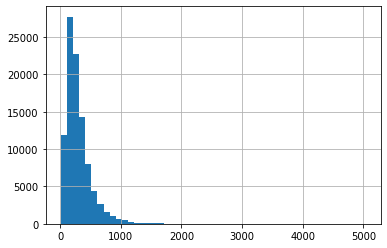

In [124]:
orders_data['delivery_time_hrs'].hist(bins=50)

### Вложенные данные, json

Начнем делать домашку, сделаем топ режиссеров

In [131]:
credits = pd.read_csv('homework/data/credits.csv')

In [132]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [148]:
json.loads(credits['cast'][0].replace("\'", "\"")[1:-1])

JSONDecodeError: Extra data: line 1 column 195 (char 194)

In [144]:
json.loads(credits['cast'][0].replace("\'", "\""))

JSONDecodeError: Expecting value: line 1 column 2416 (char 2415)

In [139]:
eval(credits['crew'][0].replace("\'", "\""))

SyntaxError: invalid syntax (<string>, line 1)

In [135]:
json.loads(credits['crew'][0])

JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 3 (char 2)